In [1]:
using NBInclude
@nbinclude("(M)_Hofstadter_Real_Space_in_Julia.ipynb")

Nx=4, Ny=4

In [2]:
p=1;q=4
alpha=p/q

0.25

In [3]:
using QuantumOptics, LinearAlgebra

In [4]:
Basis = NLevelBasis(N)

NLevel(N=16)

In [5]:
# SP
Hamiltonian_SP = SparseOperator(Basis)
for m in 1:N
    for n in 1:N
        Hamiltonian_SP = Hamiltonian_SP + HSP(Nx,Ny,alpha)[m,n] * transition(Basis, m, n)
    end
end
E0, U0 = eigenstates(dense(Hamiltonian_SP))
println(E0)

E1, U1 = eigen(HSP(Nx,Ny,alpha))
println(E1)

[-2.8284271247461903, -2.8284271247461903, -2.8284271247461885, -2.828427124746186, -9.842582652396219e-17, -5.2371492063649606e-17, 1.1952921159963832e-16, 3.920905899911496e-16, 3.1086244689504383e-15, 3.552713678800501e-15, 3.9968028886505635e-15, 4.884981308350689e-15, 2.8284271247461894, 2.8284271247461894, 2.82842712474619, 2.8284271247461903]
[-2.8284271247461903, -2.8284271247461903, -2.8284271247461885, -2.828427124746186, -9.842582652396219e-17, -5.2371492063649606e-17, 1.1952921159963832e-16, 3.920905899911496e-16, 3.1086244689504383e-15, 3.552713678800501e-15, 3.9968028886505635e-15, 4.884981308350689e-15, 2.8284271247461894, 2.8284271247461894, 2.82842712474619, 2.8284271247461903]


In [6]:
# Sp initial States band subspace
E, states0 = eigenstates(dense(Hamiltonian_SP))
Ncut=4 #subspace size
states = states0[1:Ncut]
#states = states0

# SubspaceBasis( SP Basis, Restricted States)
b_sub = SubspaceBasis(Basis,states)

# projector( Subspace Basis, SP Basis )
P = projector(b_sub, Basis)
Pt = dagger(P)

# New SP Subspace Operator
H_sub = P*Hamiltonian_SP*Pt 

Operator(dim=4x4)
  basis: Subspace(superbasis=NLevel(N=16), states:4)
 -2.82843-0.0im      -2.2e-16+2.8e-16im  …       0.0-3.0e-17im
      0.0-1.7e-16im  -2.82843+1.1e-16im     -1.1e-16-8.0e-17im
  3.0e-17-8.0e-17im  -1.1e-16-5.0e-17im          0.0+0.0im
      0.0+0.0im      -1.1e-16+3.0e-17im     -2.82843-0.0im

In [7]:
Nparticles = 2

2

In [8]:
StatesBH = bosonstates(b_sub, Nparticles) 
Basis_MB = ManyBodyBasis(b_sub, StatesBH)

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=16), states:4), states:10)

In [9]:
#FINITE U Model

U=1/1000

NM_MB_Array_Storage = zeros(Complex{Float64},length(Basis_MB),length(Basis_MB),N)
NM_MB_Matrix = zeros(Complex{Float64},length(Basis_MB),length(Basis_MB))
    
# projecting number operator to the regarding to subspace 
IT = SparseOperator(Basis_MB)
for m in 1:N
    NM = transition(Basis, m, m)
    NMP = P*NM*Pt
    # Auto (slower)
    #NM_MB_1 = manybodyoperator(Basis_MB, NMP)
    # Manuel (faster)
    NM_MB_2 = SparseOperator(Basis_MB)
    for i in 1:length(b_sub)
        for j in 1:length(b_sub)
            NM_MB_2 = NM_MB_2 + NMP.data[i,j] * transition(Basis_MB, i, j)
        end
    end
    # NM_MB_1 == NM_MB_2 (true)
    
    # Convert NM_MB operator into the NM_MB_Matrix matrix to storage all of NM_MB operator according to each m index
    for i in 1:length(Basis_MB)
        for j in 1:length(Basis_MB)
            NM_MB_Matrix[i,j] = NM_MB_2.data[i,j]
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
    # end
    
    IT = IT + U/2 * NM_MB_2 * ( NM_MB_2 - identityoperator(Basis_MB) )
end

KT = SparseOperator(Basis_MB)
for m in 1:length(b_sub)
    for n in 1:length(b_sub)
        KT = KT + H_sub.data[m,n] * transition(Basis_MB, m, n)
    end
end
MB_Hamiltonian = KT + IT
x = MB_Hamiltonian
EEE, UUU = eigenstates(dense((x+dagger(x))/2))
EEE

10-element Vector{Float64}:
 -5.65759888784003
 -5.657598887840029
 -5.657541749492381
 -5.657541749492379
 -5.657479249492384
 -5.657479249492382
 -5.657479249492381
 -5.657479249492378
 -5.657422111144734
 -5.657422111144732

U çok küçükken (Band-Gap büyüdüğünde) subspace enerjileri, real-space enerjilerine yakınsar:

Nx=4, Ny=4Nx=4, Ny=4

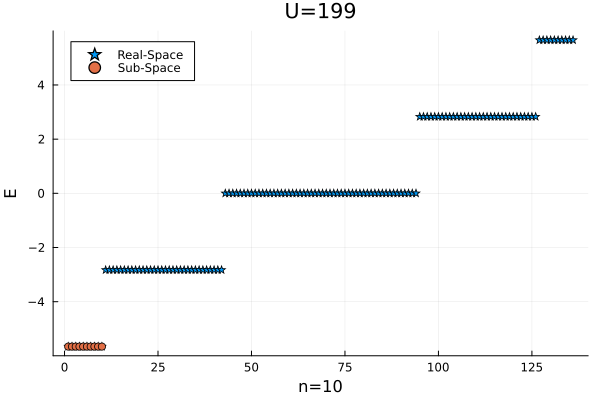

In [14]:
using Plots
@nbinclude("Hofstadter MB in Julia.ipynb")
real_space_finite_u = MB_Energies; sub_space_finite_u = EEE
plot(1:length(real_space_finite_u),real_space_finite_u,seriestype=:scatter,markershape=:star5,label="Real-Space")
plot!(1:length(sub_space_finite_u),sub_space_finite_u,seriestype=:scatter,label="Sub-Space",legend=:topleft)
title!("U=$(U)");xlabel!("n=$(length(EEE))");ylabel!("E")